In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cartilage/data/train(0,3,4)/0/0_307.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_249.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_217.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_354.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_287.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_31.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_16.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_168.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_419.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_228.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_24.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_362.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_49.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_293.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_45.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_135.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_455.jpg
/kaggle/input/cartilage/data/train(0,3,4)/0/0_96.jpg
/kaggle/input/cartilage/data/train

In [19]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Feature Extraction Function using HOG
def extract_hog_features(image):
    image_resized = cv2.resize(image, (128, 128))  # Resizing the image
    features, _ = hog(image_resized, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return features

# Load images and labels from folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        for filename in os.listdir(label_folder):
            img = cv2.imread(os.path.join(label_folder, filename))
            if img is not None:
                images.append(img)
                labels.append(int(label))  # assuming the folder name is the class label
    return images, labels

# Load datasets
train_folder = r'/kaggle/input/cartilage/data/train(0,3,4)'
val_folder = r'/kaggle/input/cartilage/data/val(0,3,4)'
test_folder = r'/kaggle/input/cartilage/data/test(0,3,4)'

train_images, train_labels = load_images_from_folder(train_folder)
val_images, val_labels = load_images_from_folder(val_folder)
test_images, test_labels = load_images_from_folder(test_folder)

# Mapping original labels to new labels
label_mapping = {0: 0, 3: 1, 4: 2}
y_train = [label_mapping[label] for label in train_labels]
y_val = [label_mapping[label] for label in val_labels]
y_test = [label_mapping[label] for label in test_labels]

# Feature extraction for all images
train_features = [extract_hog_features(image) for image in train_images]
val_features = [extract_hog_features(image) for image in val_images]
test_features = [extract_hog_features(image) for image in test_images]

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_features)
X_val = scaler.transform(val_features)
X_test = scaler.transform(test_features)

# Apply PCA for dimensionality reduction 
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
}

# Set up GridSearchCV
grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, verbose=0, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_pca, y_train)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Function to evaluate model
def evaluate_model(model, X, y_true, dataset_type='Train'):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y_true, y_pred)
    loss = log_loss(y_true, y_pred_proba)
    
    print(f"{dataset_type} Accuracy: {accuracy * 100:.2f}%")
    print(f"{dataset_type} Log Loss: {loss:.4f}")
    print(f"Confusion Matrix for {dataset_type} Set:\n", confusion_matrix(y_true, y_pred))
    print("\n")
    
    return accuracy, loss

# Evaluate the best model on Train, Validation, and Test sets
evaluate_model(best_svm_model, X_train_pca, y_train, dataset_type='Train')
evaluate_model(best_svm_model, X_val_pca, y_val, dataset_type='Validation')
evaluate_model(best_svm_model, X_test_pca, y_test, dataset_type='Test')

# Inference Functions

# Function to preprocess and extract HOG features from a single image
def preprocess_image(image_path, scaler, pca):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to read image file.")
    
    # Extract HOG features
    features = extract_hog_features(image)
    
    features_scaled = scaler.transform([features])  
    features_pca = pca.transform(features_scaled)
    
    return features_pca

# Prediction using the best SVM model
def predict_with_svm_model(model, image_path, scaler, pca):
    features_pca = preprocess_image(image_path, scaler, pca)
    predicted_label = model.predict(features_pca)
    return predicted_label[0]

image_path = '/kaggle/input/cartilage/data/test(0,3,4)/3/9011053L.png'  
predicted_label_svm = predict_with_svm_model(best_svm_model, image_path, scaler, pca)
print(f"SVM Predicted Label: {predicted_label_svm}")


Train Accuracy: 100.00%
Train Log Loss: 0.0037
Confusion Matrix for Train Set:
 [[500   0   0]
 [  0 500   0]
 [  0   0 500]]


Validation Accuracy: 85.68%
Validation Log Loss: 0.5994
Confusion Matrix for Validation Set:
 [[310  18   0]
 [ 21  85   0]
 [  1  26   0]]


Test Accuracy: 84.01%
Test Log Loss: 0.6349
Confusion Matrix for Test Set:
 [[605  34   0]
 [ 61 162   0]
 [  1  50   0]]


SVM Predicted Label: 1


In [20]:
import joblib 

# Save the trained SVM model and scaler to disk
joblib.dump(best_svm_model, 'svm_model.pkl') 
joblib.dump(scaler, 'scaler.pkl')  
joblib.dump(pca, 'pca.pkl')  


['pca.pkl']

In [21]:
import joblib

loaded_svm_model = joblib.load('svm_model.pkl')  # Load the SVM model
loaded_scaler = joblib.load('scaler.pkl')  
loaded_pca = joblib.load('pca.pkl')  


SVM Predicted Label: 0


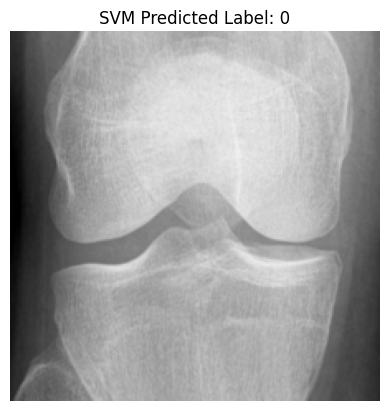

In [23]:
import cv2
import matplotlib.pyplot as plt

def preprocess_image(image_path, scaler, pca):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to read image file.")
    
    # Extract HOG features (assuming you have the extract_hog_features function)
    features = extract_hog_features(image)
    
    # Scale the features using the same scaler used during training
    features_scaled = scaler.transform([features])  # Note the double brackets to keep it as 2D array
    features_pca = pca.transform(features_scaled)
    
    return features_pca

def predict_with_svm_model(model, image_path, scaler, pca):
    features_pca = preprocess_image(image_path, scaler, pca)
    predicted_label = model.predict(features_pca)
    return predicted_label[0]

# Define the image path (replace this with your actual image path)
image_path = '/kaggle/input/cartilage/data/test(0,3,4)/0/9003175R.png'

# Perform prediction with the SVM model
predicted_label_svm = predict_with_svm_model(loaded_svm_model, image_path, loaded_scaler, loaded_pca)

# Print the predicted label
print(f"SVM Predicted Label: {predicted_label_svm}")

# Display the image along with the predicted label
image = cv2.imread(image_path)

# Convert BGR (OpenCV default) to RGB (for matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axis
plt.title(f"SVM Predicted Label: {predicted_label_svm}")  # Show the predicted label as title
plt.show()